In [1]:
# Import Libraries

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
from scipy.stats import norm
from hw2utils import LossFunctionWithPlot, ConstantVectorNetwork

In [2]:
# Loading the data
import numpy
train_data, train_labels, test_data, test_labels = [
    torch.tensor(m[k]).float()
    for m in [numpy.load('tiny-classification.npz')]
    for k in 'train_data train_labels val_data val_labels'.split()]

print(f'The training data has {train_data.size(0)} samples, each a vector of {train_data.size(1)} numbers along with')
print(f'a corresponding set of {train_labels.size(0)} labels, assigning {train_labels.min()} or {train_labels.max()} to each sample.')

print(f'The test data has {test_data.size(0)} samples and labels that are disjoint from the training data.')

The training data has 8000 samples, each a vector of 36 numbers along with
a corresponding set of 8000 labels, assigning 0.0 or 1.0 to each sample.
The test data has 1000 samples and labels that are disjoint from the training data.


In [3]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, hidden_dims=16, fan_out_dims=32):
        super().__init__()
        self.fan_out = nn.Sequential(
            nn.BatchNorm1d(hidden_dims), 
            nn.Linear(hidden_dims, fan_out_dims)
        )
        self.fan_in = nn.Sequential(
            nn.ReLU(), 
            nn.Linear(fan_out_dims, hidden_dims)
        )
    
    def forward(self, x):
        add = self.fan_out(x)
        add = self.fan_in(add)
        return x + add

input_size=train_data.size(1)
hidden_dims= 16
fan_out_dims= 32
output_dims=1

resnet_hard = nn.Sequential(
    nn.Linear(input_size, hidden_dims),
    ResidualBlock(hidden_dims, fan_out_dims),
    ResidualBlock(hidden_dims, fan_out_dims),
    nn.BatchNorm1d(hidden_dims),
    nn.Linear(hidden_dims, output_dims),
    nn.Sigmoid()
)

# initializing weights pretrained with tiny data
resnet_hard.load_state_dict(torch.load('resnet_hard.pth'))
resnet_hard.eval()

Sequential(
  (0): Linear(in_features=36, out_features=16, bias=True)
  (1): ResidualBlock(
    (fan_out): Sequential(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (fan_in): Sequential(
      (0): ReLU()
      (1): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (2): ResidualBlock(
    (fan_out): Sequential(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (fan_in): Sequential(
      (0): ReLU()
      (1): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [4]:
with torch.no_grad():
    test_outputs = resnet_hard(test_data.float())
    test_preds = (test_outputs.squeeze() > 0.5).float()
    test_accuracy = (test_preds == test_labels).float().mean()
test_accuracy

tensor(0.9990)

In [5]:
test_one = torch.stack([sample for sample, label  in zip(test_data, test_labels) if label == 1])
test_zero = torch.stack([sample for sample, label  in zip(test_data, test_labels) if label == 0])

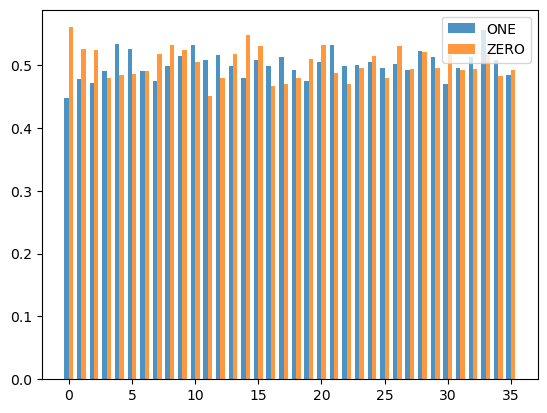

In [6]:
x = np.arange(test_one.shape[-1])
barwidth = 0.35

one_means = test_one.mean(dim=0).numpy()
one_stds = test_one.std(dim=0).numpy()
zero_means = test_zero.mean(dim=0).numpy()
zero_stds = test_zero.std(dim=0).numpy()

plt.bar(x-barwidth/2, one_means, width=barwidth, alpha=0.8, label='ONE')
plt.bar(x+barwidth/2, zero_means, width=barwidth, alpha=0.8, label='ZERO')

# plt.vlines(
#     x-barWidth/2,
#     one_means - one_stds,
#     one_means + one_stds,
#     colors='black',
# )
# plt.scatter(x-barWidth/2, one_means - one_stds, color='black', s=10, marker='_')
# plt.scatter(x-barWidth/2, one_means + one_stds, color='black', s=10, marker='_')

# plt.vlines(
#     x+barWidth/2,
#     zero_means - zero_stds,
#     zero_means + zero_stds,
#     colors='black',
# )
# plt.scatter(x+barWidth/2, zero_means - zero_stds, color='black', s=10, marker='_')
# plt.scatter(x+barWidth/2, zero_means + zero_stds, color='black', s=10, marker='_')

# plt.xticks(x, [f'{i}' for i in range(x.shape[0])])
plt.legend()

In [7]:
import baukit

In [12]:
baukit.get_module(resnet_hard, "1.fan_out")

Sequential(
  (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=16, out_features=32, bias=True)
)